In [1]:
import numpy as np
import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import random
import os

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)


In [3]:
# 1. 텍스트 데이터 불러오기
# 'sherlock.txt' 파일은 셜록 홈즈 원문으로, 각 줄이 하나의 문장입니다. (data 폴더에 있습니다.)
# 모든 문장을 소문자로 변환하여 처리의 일관성을 유지합니다.
with open('../data/sherlock.txt', 'r', encoding='utf-8') as f:
    text = f.read().lower()

In [4]:
# 2. 문장 단위 분할
# 줄바꿈 문자를 기준으로 문장을 나눕니다.
sentences = text.split('\n')

In [13]:
# 3. 토크나이저 생성 및 학습
# 텍스트 데이터를 단어 단위로 나누고, 각 단어에 고유 번호를 부여합니다.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
total_words = len(tokenizer.word_index) + 1  # 전체 단어 수 (+1은 패딩을 고려)

In [18]:
# 4. n-gram 시퀀스 생성
# 문장 내 단어들을 기반으로 [단어1, 단어2], [단어1, 단어2, 단어3], ... 등
# 누적 시퀀스를 생성하여 다음 단어 예측 학습용 데이터로 만듭니다.
input_sequences = []
for line in sentences:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        seq = token_list[:i + 1]
        input_sequences.append(seq)

# 너무 많은 데이터를 방지하기 위해 상한선 설정 (50,000개 시퀀스까지만)
input_sequences = input_sequences[:50000]

In [19]:
# 5. 시퀀스 길이 통일: 가장 긴 시퀀스를 기준으로 앞쪽을 패딩합니다.
max_seq_len = max(len(seq) for seq in input_sequences)
input_sequences = pad_sequences(input_sequences, maxlen=max_seq_len, padding='pre')

In [20]:
# 6. 입력(X)과 정답(y) 분리
# 마지막 단어는 예측 대상(y), 나머지는 입력 시퀀스(X)입니다.
X = input_sequences[:, :-1]
y = input_sequences[:, -1]  # sparse_categorical_crossentropy는 정수 라벨 그대로 사용 가능

In [25]:
# 7. 모델 정의
# - Embedding: 단어 ID를 고정 크기 밀집 벡터로 변환
# - 시퀀스를 순차적으로 학습할 수 있는 개선된 모델 사용
# - Dense: 전체 단어 중 정답 단어를 확률로 예측
model = Sequential([
    Embedding(input_dim=total_words, output_dim=50, input_length=max_seq_len-1),
    LSTM(64), 
    Dense(total_words, activation='softmax')
])

c:\Users\SSAFY\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [26]:
# 8. 모델 컴파일
# 손실 함수: sparse_categorical_crossentropy (정수형 라벨 사용)
# 옵티마이저: Adam (빠르고 안정적인 학습)
model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='adam',
    metrics=['accuracy']
      )


In [27]:
# 9. 모델 학습
# 적절한 에포크 수로 반복 학습 (시간 문제로 10 에포크 설정)
history = model.fit(X, y, epochs=10, batch_size=128)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.0475 - loss: 6.7024
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.0497 - loss: 6.2001
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.0546 - loss: 6.0895
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.0614 - loss: 5.9835
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.0688 - loss: 5.8903
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.0773 - loss: 5.8023
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.0874 - loss: 5.7051
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.1006 - loss: 5.5893
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.1104 - loss: 5.4743
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.1209 - loss: 5.3723


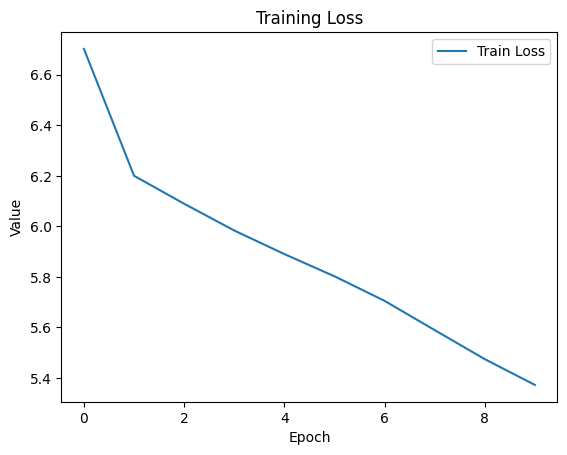

In [28]:
# 10. 학습 결과 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss')
plt.legend()
plt.show()


In [29]:
# 11. 다음 단어 예측 함수 정의
# 주어진 문장을 입력하면 다음에 올 단어를 예측합니다.
def predict_next_word(model, tokenizer, text):
    # 입력 텍스트를 시퀀스로 변환
    token_list = tokenizer.texts_to_sequences([text])[0]
    # 모델 입력 형태에 맞게 패딩
    token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')
    # 예측 확률 계산
    pred = model.predict(token_list, verbose=0)
    # 가장 높은 확률의 인덱스 선택
    next_index = np.argmax(pred)
    # 인덱스를 단어로 변환하여 반환
    return tokenizer.index_word.get(next_index, '[UNK]')

In [30]:
# 12. 예측 테스트
# 임의의 문장을 넣고 그 다음에 나올 단어를 예측해봅니다.
test_phrases = [
    "the detective was",
    "he looked at",
    "it was a",
    "the room was"
]

for phrase in test_phrases:
    predicted = predict_next_word(model, tokenizer, phrase)
    print(f"{phrase} → {predicted}")

the detective was → a
he looked at → the
it was a → man
the room was → a
